In [1]:
import numpy as np
from numpy.polynomial import polynomial as np_poly
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
from math import sqrt, pi, exp, erf
from numpy import vectorize

In [2]:
%matplotlib notebook

In [3]:
# Boundaries of x0 grid
bounds_x0 = (-5, 5)

# Number of X0 grid points
Nx0 = 200

# The x0 grid interval
dx0 = (bounds_x0[1] - bounds_x0[0])/Nx0

# Boundaries of t grid
bounds_t = (0, 10)

# Initial Probability Distribution Variables
mu = 0
sigma = 10

# Constants of the experiment
h = 1
mass = 10
h2_m = h*h/mass

# Initial kinetic energy (used to determine velocity)
K0 = 1

In [4]:
# Polynomial Regression Degree
degree=10

# Perform polynomial regression
def coefficients(X, Y):
    return np_poly.polyfit(X, Y, degree)

def poly_func(X, coeff):
    y = np.zeros((X.shape))
    tmp = np.ones((X.shape))
    for i in range(0, degree):
        u = coeff[i] * tmp
        y += u
        tmp *= X
    
    return y

# Polynomial derivative
def poly_derive1(X, coeff):
    der = np.zeros((X.shape))
    tmp = np.ones((X.shape))
    for i in range(1, degree):
        der += i * coeff[i] * tmp
        tmp *= X
    
    return der

# Polynomial derivative
def poly_derive2(X, coeff):
    der = np.zeros((X.shape))
    tmp = np.ones((X.shape))
    for i in range(2, degree):
        der += i * (i-1) * coeff[i] * tmp
        tmp *= X
    
    return der

# Polynomial derivative
def poly_derive3(X, coeff):
    der = np.zeros((X.shape))
    tmp = np.ones((X.shape))
    for i in range(3, degree):
        der += i * (i-1) * (i-2) * coeff[i] * tmp
        tmp *= X
    
    return der

# Polynomial derivative
def poly_derive4(X, coeff):
    der = np.zeros((X.shape))
    tmp = np.ones((X.shape))
    for i in range(4, degree):
        der += i * (i-1) * (i-2) * (i-3) * coeff[i] * tmp
        tmp *= X
    
    return der

In [5]:
# Coefficient to obtain truncated Gaussian
C = 0.5 * (erf((bounds_x0[1])/(sigma*sqrt(2))) - erf((bounds_x0[0])/(sigma*sqrt(2))))

# Computes a truncated Gaussian w.r.t bounds_x0, sigma, and mu.
def gaussian(x):
    return 1/(C*sigma*sqrt(2*pi)) * exp(-0.5*((x-mu)/sigma)**2) if bounds_x0[0] <= x <= bounds_x0[1] else 0

# Computes the classical potential
def potential(x):
    return (x-2)**2

# Computes the classical force (-grad(V))
def force(x):
    return -2*(x-2)

# Computes the initial quantum potential
def initial_quantum_potential(x):
    return -0.5 * h2_m * ratio2(x)

# Computes the initial quantum force
def initial_quantum_force(x):
    return -0.5 * h2_m  * -(x-mu)/(2*(sigma**4))

# Computes the initial acceleration for a particle at x
def initial_acceleration(x):
    return 1/mass * (force(x) + initial_quantum_force(x))

# Computes the initial R function at time t=0
def R0(x):
    return sqrt(gaussian(x))

# Computes the ratio R0'(x)/R0(x), assuming a Gaussian distribution
def ratio1(x):
    return -0.5 * (x-mu)/(sigma*sigma)

# Computes the ratio R0"(x)/R0(x), assuming a Gaussian distribution
def ratio2(x):
    return -0.5 / (sigma*sigma) * (1 - 0.5 * (((x-mu)/sigma)**2))

In [6]:
# Utility lambda to apply functions to a set of X values
_gaussian = vectorize(gaussian)
_potential = vectorize(potential)
_force = vectorize(force)
_initial_quantum_potential = vectorize(initial_quantum_potential)
_initial_quantum_force = vectorize(initial_quantum_force)
_initial_acceleration = vectorize(initial_acceleration)
_R0 = vectorize(R0)
_ratio1 = vectorize(ratio1)
_ratio2 = vectorize(ratio2)

In [7]:
x_plot = np.linspace(-5, 5, 1000)
fig1 = plt.figure()
plt.plot(x_plot, _gaussian(x_plot), label="Initial Probability")
plt.plot(x_plot, _initial_quantum_force(x_plot), label="Initial Quantum Force")

plt.axhline(linestyle="--", color="gray")
plt.legend()
fig1.show()

<IPython.core.display.Javascript object>

In [8]:
def ode_derive(t, y):
    pos = y[0:Nx0]
    vel = y[Nx0:2*Nx0]
    
    if t == 0:
        return np.concatenate((vel, _initial_acceleration(pos), [0]))
    
    c = coefficients(x0, pos)
    der1 = poly_derive1(pos, c)
    der2 = poly_derive2(pos, c)
    der3 = poly_derive3(pos, c)
    der4 = poly_derive4(pos, c)
    
    m = np.min(der1)
        
    ratio = _ratio1(pos)
    ratio_sqr = np.square(ratio)
    
    acc = 1/mass * (
                  _force(pos)
                + (der1**-3) * (der1*_initial_quantum_force(pos) 
                + 4*der2*_initial_quantum_potential(pos) 
                + h2_m * (
                      ratio_sqr*der2
                    + 3*ratio*(der2**2)/der1
                    - ratio*der3 
                    - 2.5*(der2**3)/(der1**2) 
                    + 2*der2*der3/der1 
                    - 0.25*der4)))
    
    return np.concatenate((vel, acc, [1/m]))

x0 = np.linspace(bounds_x0[0], bounds_x0[1], Nx0, dtype=np.float64)
v0 = np.full((Nx0), sqrt(2*K0/mass), dtype=np.float64)
y0 = np.concatenate((x0, v0, [0]))

def crossing(t, y):
    pos = y[0:Nx0]
    c = coefficients(x0, pos)
    der1 = poly_derive1(pos, c)
    return np.min(der1)

result = solve_ivp(ode_derive, (0, 20), y0, max_step=0.01, events=crossing)

In [9]:
fig2 = plt.figure()
for i in range(1, Nx0, 1):
    plt.plot(result.y[i], result.t)

x_plot1 = np.linspace(-5, 5, 100)
plt.plot(x_plot1, _potential(x_plot1)/10, color='red', linestyle='--')
fig2.show()

<IPython.core.display.Javascript object>

In [10]:
fig3=plt.figure()
for i in range(0, Nx0, 100):
    plt.plot(result.y[Nx0+i], result.t)

fig3.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


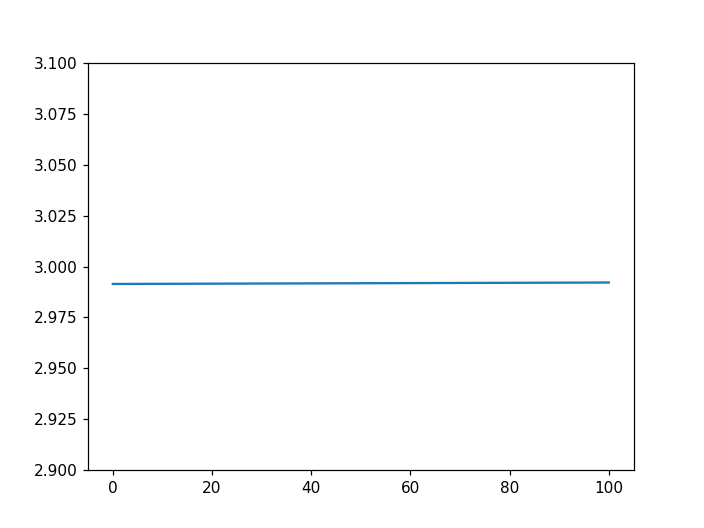

In [31]:
def data(y):
    return poly_func(y, coefficients(x0, y))

fig, ax = plt.subplots()
x_plot = np.linspace(0, 100, Nx0)
yt = np.transpose(result.y)
pos = yt[350][0:Nx0]
vel = yt[0][Nx0:2*Nx0]

d = data(pos)
line, = ax.plot(x_plot, d)
plt.ylim(2.9, 3.1)

def animate(i):
    der = data(yt[i][0:Nx0])
    line.set_ydata(der)  # update the data
    return line,

def init():
    return animate(0)

ani = animation.FuncAnimation(fig, animate, np.arange(320, 360), init_func=init, interval=100)